# Normalizing Flows with jax

In [18]:
import sbibm
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

from simulator.cosmo_jax_sim.get_cl import get_cl, fiducial_cosmo, get_cl_sigma8_omega_m, get_prior
from normflow.model import AffineCoupling, ConditionalRealNVP

2024-01-22 15:26:57.506906: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 15:26:57.506987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 15:26:57.549826: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 15:27:07.214961: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.10' #NOTE: jax preallocates GPU (default 75%)

In [3]:
print(jax.default_backend(), jax.devices())

gpu [cuda(id=0)]


In [4]:
theta_fiducial = jnp.array([values for values in fiducial_cosmo.values()])

cls = get_cl(theta_fiducial)

2024-01-22 15:15:32.489031: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/feynman/home/dap/lcs/sg276684/.conda/envs/jax_sbi/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Text(0.5, 1.0, 'Fiducial Angular $C_\\ell$')

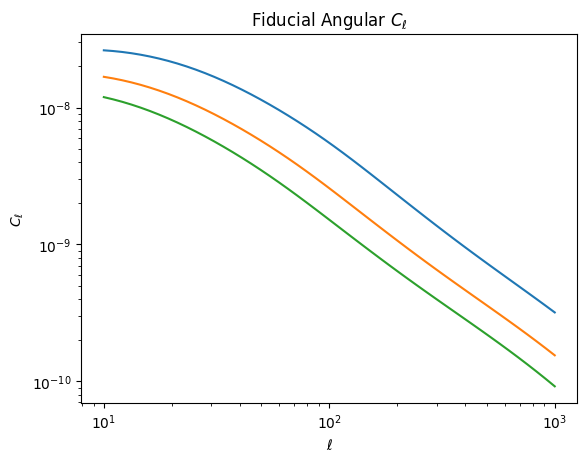

In [5]:
ell = np.logspace(1, 3)

plt.loglog(ell, cls[0])
plt.loglog(ell, cls[1])
plt.loglog(ell, cls[2])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$")
plt.title("Fiducial Angular $C_\ell$")

In [10]:
prior = get_prior(type="sigma_8_omega_m")

num_samples = 128
key = jax.random.PRNGKey(0)
samples = prior(key, num_samples)

truth = jnp.array([fiducial_cosmo['Omega_c'], fiducial_cosmo['sigma8']])

dim = 2

In [11]:
get_cl_vmap = jax.vmap(get_cl_sigma8_omega_m)

In [13]:
%timeit get_cl_vmap(samples)

27.2 ms ± 26.9 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
#Build neural density network
bijector_npe = partial(
    AffineCoupling,
    layers = [128, 128],
    activation = jax.nn.silu
)

NF_npe = partial(
    ConditionalRealNVP,
    n_layers = 4,
    bijector_fn = bijector_npe
)

#log_probability of the NDE
nvp_nd = hk.without_apply_rng(
    hk.transform(
        lambda theta, y : NF_npe(dim)(y).log_prob(theta).squeeze()
    )
)

#Sampling from the NDE
nvp_sample_nd = hk.transform(
    lambda y : NF_npe(dim)(y).sample(100_000, seed=hk.next_rng_key())
)

#Loss - negative loglikelihood
def loss_nll(params, mu, batch):
    return - jnp.mean(nvp_nd.apply(params, mu, batch))

@jax.jit
def update(params, opt_state, mu, batch):
    loss, grads = jax.value_and_grad(loss_nll)(
        params, mu, batch
    )

    updates, new_opt_state = optimizer.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)

    return loss, new_params, new_opt_state

In [28]:
#Init of nf params / can do better to avoid gradient vanishing?
params = nvp_nd.init(
    jax.random.PRNGKey(42),
    0.5 * jnp.ones([1, dim]),
    0.5 * jnp.ones([1, dim])
)

#Define optimizer
optimizer = optax.adam(learning_rate=1e-3)
opt_state = optimizer.init(params)

In [29]:
#Training
from tqdm import tqdm

key = jax.random.PRNGKey(0)

batch_size = 128
batch_loss = []
pbar = tqdm(range(5_000))

for batch in pbar:
    key, subkey = jax.random.split(key)
    thetas = prior(key, num_samples=batch_size)
    xs = get_cl_vmap(thetas)

    l, params, opt_state = update(
        params, opt_state, thetas, xs
    )
    batch_loss.append(l)
    pbar.set_description(f"loss {l:.3f}")


  0%|          | 0/5000 [00:00<?, ?it/s]


TypeError: Cannot concatenate arrays with different numbers of dimensions: got (128, 1), (128, 3, 50).